# Import Library

In [72]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import gdown
import matplotlib.pyplot as plt

In [73]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.utils import resample

In [171]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [75]:
# Load data dari google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Download file dari Google Drive
file_id = "1up5yMQPHxkF_vxi0kmzkqdTB-kn6hVx4"
output = "skin_type_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Ekstrak ZIP
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("skin-type-dataset")  # folder hasil ekstraksi

Downloading...
From (original): https://drive.google.com/uc?id=1up5yMQPHxkF_vxi0kmzkqdTB-kn6hVx4
From (redirected): https://drive.google.com/uc?id=1up5yMQPHxkF_vxi0kmzkqdTB-kn6hVx4&confirm=t&uuid=020060d6-538a-4227-8df0-bf6920c5f2aa
To: /content/skin_type_dataset.zip
100%|██████████| 82.6M/82.6M [00:00<00:00, 118MB/s]


In [77]:
dataset_path = "skin-type-dataset"
selected_classes = ['berminyak', 'kering', 'normal']
filtered_path = "filtered-skin-type-dataset"

# Hapus folder lama jika sudah ada
if os.path.exists(filtered_path):
    shutil.rmtree(filtered_path)

# Buat ulang folder filtered_path
os.makedirs(filtered_path, exist_ok=True)

# Untuk setiap split (train, valid, test)
for split in ['train', 'valid', 'test']:
    split_src = os.path.join(dataset_path, split)
    split_dst = os.path.join(filtered_path, split)

    os.makedirs(split_dst, exist_ok=True)

    for class_name in selected_classes:
        src_class_dir = os.path.join(split_src, class_name)
        dst_class_dir = os.path.join(split_dst, class_name)

        # Cek apakah folder kelas ada
        if os.path.exists(src_class_dir):
            shutil.copytree(src_class_dir, dst_class_dir)

In [78]:
# Buat tabel path data dan labelnya
data_dir = '/content/filtered-skin-type-dataset'
filepaths = []
labels = []

## Buat Dataframe Gambar dan Label

In [79]:
import os
import pandas as pd

data_dir = '/content/filtered-skin-type-dataset'
filepaths = []
labels = []
splits = []

# Loop melalui folder split: train, valid, test
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(data_dir, split)

    # Loop kelas dalam masing-masing split
    for label in os.listdir(split_path):
        class_path = os.path.join(split_path, label)

        # Loop semua file gambar dalam folder kelas
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)

            filepaths.append(fpath)
            labels.append(label)
            splits.append(split)

# Buat DataFrame
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels,
    'split': splits
})


In [80]:
# hitung jumlah label
df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/train/norm...,normal,train
1,/content/filtered-skin-type-dataset/train/norm...,normal,train
2,/content/filtered-skin-type-dataset/train/norm...,normal,train
3,/content/filtered-skin-type-dataset/train/norm...,normal,train
4,/content/filtered-skin-type-dataset/train/norm...,normal,train


In [81]:
# Jumlah data : 13711 data gamba
df.shape

(3962, 3)

In [82]:
# Jumlah gambar pada tiap kelas
df['label'].value_counts()

,count
label,
berminyak,1803
normal,1124
kering,1035


## Data Visualization

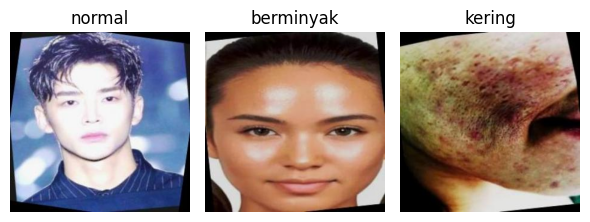

In [83]:
# Cek gambar pada dataset
# Ambil gambar pertama dari setiap kelas unik
unique_classes = list(set(labels))
selected_images = {}

for filepath, label in zip(filepaths, labels):
    if label not in selected_images:
        selected_images[label] = filepath
    if len(selected_images) == 10:
        break

# Tampilkan gambar
fig, axes = plt.subplots(1, 3, figsize=(6, 3))  # Grid 2x5
for ax, (label, img_path) in zip(axes.flat, selected_images.items()):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

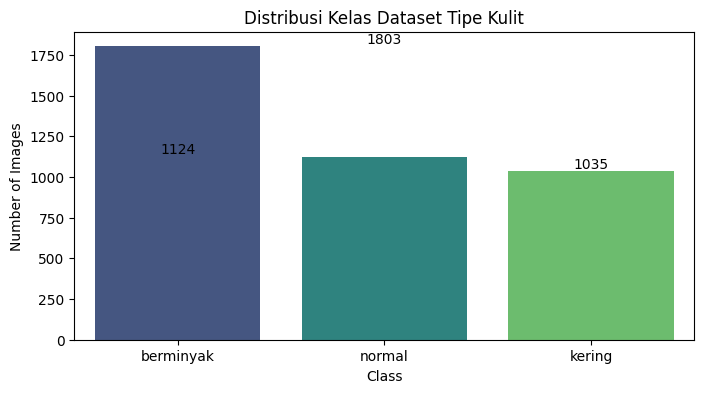

In [84]:
import seaborn as sns
from collections import Counter

class_counts = Counter(labels)
df_counts = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

plt.figure(figsize=(8, 4))
barplot = sns.barplot(x="Class", y="Count", data=df_counts, palette='viridis')
for index, row in df_counts.iterrows():
    barplot.text(x=index, y=row["Count"] + 1, s=str(row["Count"]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribusi Kelas Dataset Tipe Kulit")
plt.show()

In [85]:
# Menyimpan ukuran (width, height)
widths = []
heights = []
df_img_resolution = df.copy()

# Loop semua baris dataframe
for path in df_img_resolution['filepath']:
    with Image.open(path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Tambahkan ke DataFrame
df_img_resolution['width'] = widths
df_img_resolution['height'] = heights

# Hitung rata-rata width dan height untuk setiap split
avg_resolution = df_img_resolution.groupby('split')[['width', 'height']].mean().round(2)
avg_resolution


,width,height
split,,
test,300.0,300.0
train,300.0,300.0
valid,300.0,300.0


# Data Preprocessing

## Undersampling Training Data

In [86]:
# Path output untuk data hasil undersampling
undersampled_dir = '/content/filtered-skin-type-dataset/train_undersampled'
os.makedirs(undersampled_dir, exist_ok=True)

# Ambil hanya data split 'train'
train_df = df[df['split'] == 'train']

# Hitung jumlah minimum di antara semua kelas
class_counts = train_df['label'].value_counts()
min_count = class_counts.min()

In [87]:
# Undersampling setiap kelas ke jumlah minimal
df_undersampled = pd.concat([
    resample(train_df[train_df['label'] == label],
             replace=False,
             n_samples=min_count,
             random_state=42)
    for label in class_counts.index
])

In [88]:
# Salin file hasil undersampling ke direktori baru
for _, row in df_undersampled.iterrows():
    label = row['label']
    src_path = row['filepath']
    dst_class_dir = os.path.join(undersampled_dir, label)
    os.makedirs(dst_class_dir, exist_ok=True)
    dst_path = os.path.join(dst_class_dir, os.path.basename(src_path))

    shutil.copy2(src_path, dst_path)

In [89]:
label_counts = Counter(df_undersampled['label'])
print("Distribusi kelas hasil undersampling:")
for label, count in label_counts.items():
    print(f"{label}: {count} gambar")

Distribusi kelas hasil undersampling:
berminyak: 807 gambar
normal: 807 gambar
kering: 807 gambar


In [90]:
df_undersampled

,filepath,label,split
1939,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
1359,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
1514,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
1519,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
1818,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
...,...,...,...
2340,/content/filtered-skin-type-dataset/train/keri...,kering,train
2375,/content/filtered-skin-type-dataset/train/keri...,kering,train
2539,/content/filtered-skin-type-dataset/train/keri...,kering,train
2704,/content/filtered-skin-type-dataset/train/keri...,kering,train


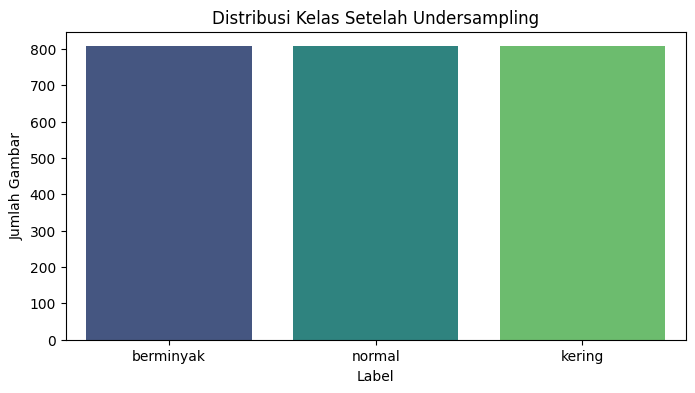

In [91]:
plt.figure(figsize=(8, 4))
sns.barplot(x=df_undersampled['label'].value_counts().index, y=df_undersampled['label'].value_counts().values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Kelas Setelah Undersampling')
plt.show()

## Split Dataset

In [92]:
# Split dataset menjadi menjadi dataframe train, val, dan test
train_df = df_undersampled[df_undersampled['split'] == 'train'].reset_index(drop=True)
val_df = df[df['split'] == 'valid'].reset_index(drop=True)
test_df  = df[df['split'] == 'test'].reset_index(drop=True)

# Cek jumlah data tiap split
print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(val_df)}")
print(f"Test size:  {len(test_df)}")

Train size: 2421
Valid size: 786
Test size:  100


In [93]:
# Cek jumlah citra per kelas
print("Jumlah gambar per kelas di Training Set:")
print(train_df['label'].value_counts())

print("\nJumlah gambar per kelas di Validation Set:")
print(val_df['label'].value_counts())

print("\nJumlah gambar per kelas di Test Set:")
print(test_df['label'].value_counts())

Jumlah gambar per kelas di Training Set:
label
berminyak    807
normal       807
kering       807
Name: count, dtype: int64

Jumlah gambar per kelas di Validation Set:
label
berminyak    349
normal       233
kering       204
Name: count, dtype: int64

Jumlah gambar per kelas di Test Set:
label
berminyak    50
normal       26
kering       24
Name: count, dtype: int64


In [94]:
# Cek train df
train_df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
1,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
2,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
3,/content/filtered-skin-type-dataset/train/berm...,berminyak,train
4,/content/filtered-skin-type-dataset/train/berm...,berminyak,train


In [95]:
# Cek val df
val_df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
1,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
2,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
3,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
4,/content/filtered-skin-type-dataset/valid/norm...,normal,valid


In [96]:
# Cek test df
test_df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/test/norma...,normal,test
1,/content/filtered-skin-type-dataset/test/norma...,normal,test
2,/content/filtered-skin-type-dataset/test/norma...,normal,test
3,/content/filtered-skin-type-dataset/test/norma...,normal,test
4,/content/filtered-skin-type-dataset/test/norma...,normal,test


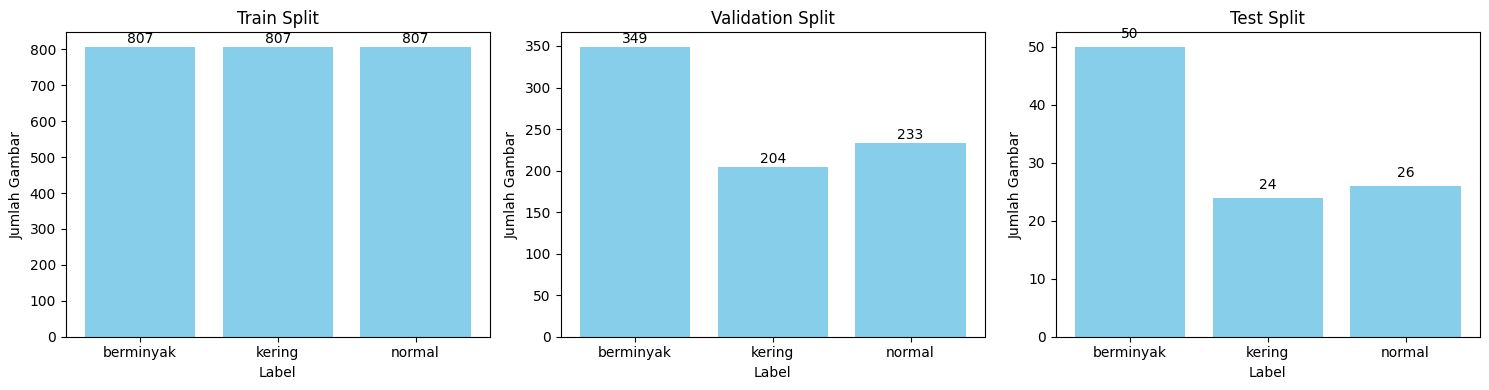

In [97]:
# Plot distribusi data
splits = [train_df, val_df, test_df]
titles = ['Train', 'Validation', 'Test']
# Buat figure dan 3 axes (1 baris, 3 kolom)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, df_split, title in zip(axes, splits, titles):
    label_counts = df_split['label'].value_counts().sort_index()
    bars = ax.bar(label_counts.index, label_counts.values, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval),
                ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{title} Split')
    ax.set_xlabel('Label')
    ax.set_ylabel('Jumlah Gambar')

plt.tight_layout()
plt.show()

## Augmentasi dan Normalisasi

In [98]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

## Image Resizing

In [156]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 2421 validated image filenames belonging to 3 classes.
Found 786 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


# Modelling

## Membuat Callback

In [148]:
# Callback kustom untuk menghentikan training jika val_accuracy & accuracy > 90%
class AccuracyOnTarget(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if logs.get('val_accuracy') > 0.90 and logs.get('accuracy') > 0.90:
            print('\n🎯 Val Accuracy dan Training Accuracy telah mencapai > 90%! Training dihentikan.')
            self.model.stop_training = True

# Subclass dari EarlyStopping untuk menambahkan pesan saat training dihentikan
class EarlyStoppingWithMessage(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"\n🛑 Training dihentikan oleh EarlyStopping pada epoch {self.stopped_epoch + 1}. "
                  f"Val accuracy tidak membaik selama {self.patience} epoch.")

# Fungsi untuk mengembalikan semua callback yang dibutuhkan
def get_callbacks():
    accuracy_callback = AccuracyOnTarget()
    early_stop_callback = EarlyStoppingWithMessage(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    return [accuracy_callback, early_stop_callback]


## CNN

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

model_1 = Sequential()

model_1.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Output sesuai jumlah kelas

model_1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,731 (631.76 KB)

 Trainable params: 161,283 (630.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [123]:
model_1.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [124]:
# Train the model
history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.4704 - loss: 1.0527 - val_accuracy: 0.3931 - val_loss: 1.0981
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step - accuracy: 0.5666 - loss: 0.9220 - val_accuracy: 0.2583 - val_loss: 1.2789
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 398ms/step - accuracy: 0.6132 - loss: 0.8497 - val_accuracy: 0.3372 - val_loss: 1.3534
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 393ms/step - accuracy: 0.6244 - loss: 0.8312 - val_accuracy: 0.2176 - val_loss: 1.7617
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 415ms/step - accuracy: 0.6686 - loss: 0.7774 - val_accuracy: 0.3295 - val_loss: 1.3415
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.6993 - loss: 0.7205 - val_accuracy: 0.3562 - val_loss: 1.1724
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step - accuracy: 0.7161 - loss: 0.6881 - val_accuracy: 0.4135 - val_loss: 2.2559
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 417ms/step - accuracy: 0.7251 - loss: 0.6530 - 

In [129]:
# Saved the model
# Keras
model_1.save("cnn_skin_type_model.keras")
# Save to drive
model_1.save('/content/drive/MyDrive/cnn_skin_type_model.keras')

In [152]:
# Save history
import json
# Saat selesai training
with open('cnn_history.json', 'w') as f:
    json.dump(history_1.history, f)
with open('/content/drive/MyDrive/cnn_history.json', 'w') as f:
    json.dump(history_1.history, f)

## ResNet50

In [122]:
# Load ResNet50 tanpa top (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer pretrained
base_model.trainable = False

# Tambahkan head klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 kelas

model_2 = Model(inputs=base_model.input, outputs=predictions)
model_2.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [126]:
model_2.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [127]:
# Train the model
history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 581ms/step - accuracy: 0.3396 - loss: 1.2584 - val_accuracy: 0.3715 - val_loss: 1.1089
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 425ms/step - accuracy: 0.3587 - loss: 1.1055 - val_accuracy: 0.4097 - val_loss: 1.1047
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 444ms/step - accuracy: 0.3746 - loss: 1.0954 - val_accuracy: 0.4746 - val_loss: 1.0623
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 426ms/step - accuracy: 0.3651 - loss: 1.1017 - val_accuracy: 0.4631 - val_loss: 1.0547
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 436ms/step - accuracy: 0.3928 - loss: 1.0849 - val_accuracy: 0.4771 - val_loss: 1.0407
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.3794 - loss: 1.0857 - val_accuracy: 0.2977 - val_loss: 1.0683
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 439ms/step - accuracy: 0.3960 - loss: 1.0753 - val_accuracy: 0.5382 - val_loss: 1.0201
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 417ms/step - accuracy: 0.4151 - loss: 1.0692 - 

In [128]:
# Saved the model
# Keras
model_2.save("resnet50_skin_type_model.keras")
# Save to drive
model_2.save('/content/drive/MyDrive/resnet50_skin_type_model.keras')

In [153]:
# Save history
with open('restnet50_history.json', 'w') as f:
    json.dump(history_2.history, f)
with open('/content/drive/MyDrive/restnet50_history.json', 'w') as f:
    json.dump(history_2.history, f)

## MobileNetV2

In [142]:
# Load base model MobileNetV2 pretrained dari ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Tambahkan head klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Bentuk model akhir
model_3 = Model(inputs=base_model.input, outputs=predictions)

model_3.summary()


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [143]:
# Compile model
model_3.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [144]:
# Train the model
history_3 = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 506ms/step - accuracy: 0.6050 - loss: 0.9029 - val_accuracy: 0.7481 - val_loss: 0.6035
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 392ms/step - accuracy: 0.7811 - loss: 0.5294 - val_accuracy: 0.7990 - val_loss: 0.4559
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 391ms/step - accuracy: 0.8103 - loss: 0.4525 - val_accuracy: 0.8664 - val_loss: 0.3513
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 395ms/step - accuracy: 0.8552 - loss: 0.3573 - val_accuracy: 0.8372 - val_loss: 0.3868
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 414ms/step - accuracy: 0.8615 - loss: 0.3405 - val_accuracy: 0.8804 - val_loss: 0.2853
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 396ms/step - accuracy: 0.8794 - loss: 0.2896 - val_accuracy: 0.8893 - val_loss: 0.2508
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 389ms/step - accuracy: 0.8836 - loss: 0.3009 - val_accuracy: 0.8995 - val_loss: 0.2353
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8996 - loss: 0.2400
🎯 V

In [146]:
# Saved the model
# Keras
model_3.save("mobilenetv2_skin_type_model.keras")
# Save to drive
model_3.save('/content/drive/MyDrive/mobilenetv2_skin_type_model.keras')

In [154]:
# Save history
with open('mobilenetv2_history.json', 'w') as f:
    json.dump(history_3.history, f)
with open('/content/drive/MyDrive/mobilenetv2_history.json', 'w') as f:
    json.dump(history_3.history, f)

## Bandingkan Performa Model

In [172]:
import pandas as pd

# Ambil nilai maksimal akurasi dan minimal loss dari tiap history
def summarize_history(history, model_name):
    acc = max(history.history['accuracy'])
    val_acc = max(history.history['val_accuracy'])
    loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])

    return {
        'Model': model_name,
        'Train Accuracy': round(acc, 4),
        'Val Accuracy': round(val_acc, 4),
        'Train Loss': round(loss, 4),
        'Val Loss': round(val_loss, 4)
    }

# Ringkasan tiap model
summary_data = [
    summarize_history(history_1, 'CNN'),
    summarize_history(history_2, 'ResNet50'),
    summarize_history(history_3, 'MobileNetV2')
]

# Buat DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,CNN,0.9674,0.9084,0.1129,0.2523
1,ResNet50,0.5192,0.5738,0.9830,0.9280
2,MobileNetV2,0.9046,0.9211,0.2443,0.2147


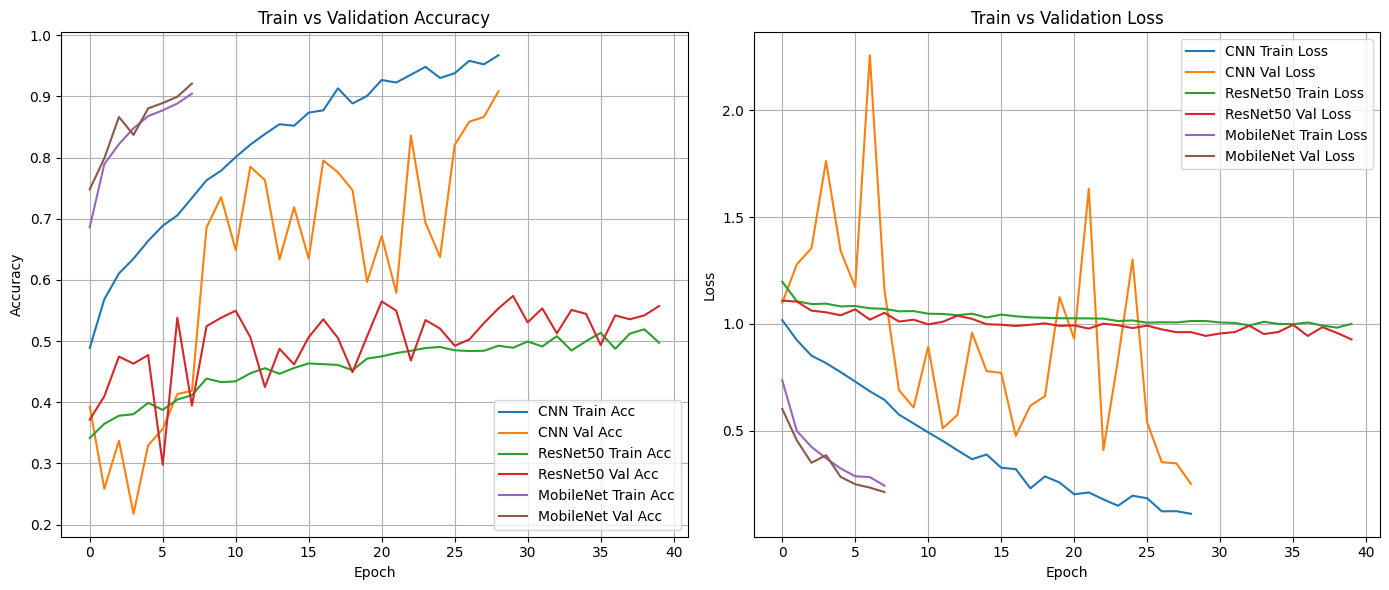

In [155]:
import matplotlib.pyplot as plt

def plot_training(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train Acc')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Panggil fungsi dengan datamu
plot_training(
    histories=[history_1, history_2, history_3],
    model_names=['CNN', 'ResNet50', 'MobileNet']
)


# Testing Model

## Test dengan Data Testing

In [163]:
best_model = model_3

In [164]:
# Evaluasi pada test set
loss, accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7632 - loss: 0.4221
Test Loss: 0.4458
Test Accuracy: 0.7700


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
              precision    recall  f1-score   support

   berminyak       0.81      0.78      0.80        50
      kering       0.72      0.75      0.73        24
      normal       0.74      0.77      0.75        26

    accuracy                           0.77       100
   macro avg       0.76      0.77      0.76       100
weighted avg       0.77      0.77      0.77       100



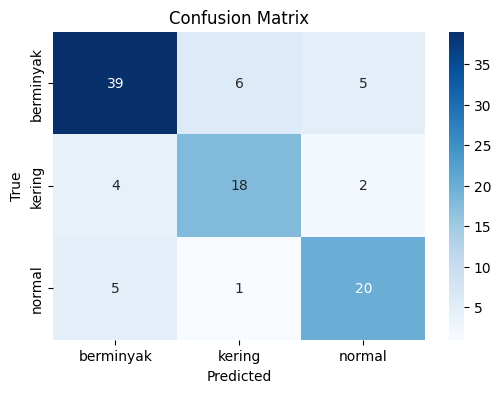

In [165]:
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Inference Model

In [166]:
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, img_path, target_size=(224, 224), class_indices=None):
    # Load dan praproses gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = best_model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    confidence_score = prediction[0][predicted_class_index]

    if class_indices:
        labels = dict((v, k) for k, v in class_indices.items())
        predicted_label = labels[predicted_class_index]
    else:
        predicted_label = predicted_class_index

    # Tampilkan gambar & hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2%}")
    plt.show()
    return predicted_label, confidence_score

Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


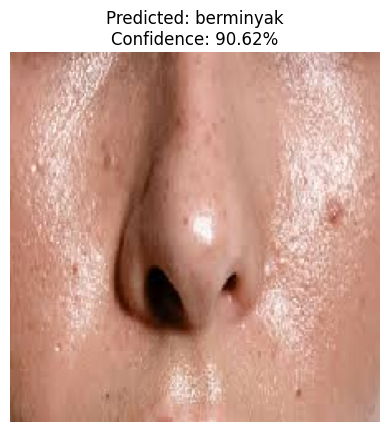

Predicted class: berminyak
Confidence score: 0.9062


In [170]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    label, confidence = predict_image(
        model=best_model,
        img_path=filename,
        target_size=(224, 224),
        class_indices=test_generator.class_indices
    )
    print(f"Predicted class: {label}")
    print(f"Confidence score: {confidence:.4f}")
